<a href="https://colab.research.google.com/github/agmCorp/colab/blob/main/ROI-Barcode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import cv2
import numpy as np
from google.colab import files
from matplotlib import pyplot as plt
import io
from PIL import Image

# Función para mostrar imágenes en Colab
def mostrar_imagen(titulo, imagen, es_gris=False):
    """Muestra una imagen usando matplotlib."""
    plt.figure(figsize=(8, 6))
    if es_gris:
        plt.imshow(imagen, cmap='gray')
    else:
        # OpenCV usa BGR, matplotlib usa RGB. Hay que convertir.
        plt.imshow(cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB))
    plt.title(titulo)
    plt.axis('off')
    plt.show()

# Sube los archivos a Colab
print("Por favor, sube las imágenes que quieres procesar:")
uploaded = files.upload()

Por favor, sube las imágenes que quieres procesar:


Saving SALIDA.png to SALIDA.png



--- Procesando imagen: SALIDA.png ---


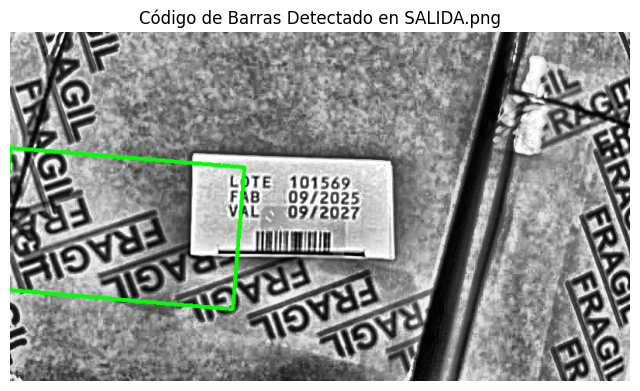

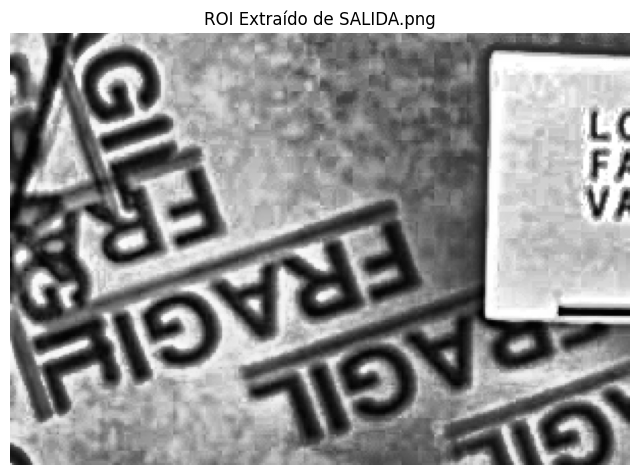

In [12]:
def encontrar_y_extraer_codigo_barras(nombre_archivo, datos_imagen):
    """
    Esta función toma los datos de una imagen, encuentra el código de barras y lo extrae.
    """
    print(f"\n--- Procesando imagen: {nombre_archivo} ---")

    # 1. Leer la imagen
    # Convertimos los datos en un array de numpy y luego lo leemos con OpenCV
    imagen_np = np.frombuffer(datos_imagen, np.uint8)
    imagen_original = cv2.imdecode(imagen_np, cv2.IMREAD_COLOR)

    # 2. Pre-procesamiento: Convertir a escala de grises
    # El color no es necesario para detectar la estructura del código de barras.
    gris = cv2.cvtColor(imagen_original, cv2.COLOR_BGR2GRAY)

    # 3. Resaltar el código de barras usando gradientes
    # Calculamos el gradiente de Scharr en la dirección X (para resaltar líneas verticales)
    # y en la dirección Y (para resaltar líneas horizontales).
    gradX = cv2.Sobel(gris, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
    gradY = cv2.Sobel(gris, ddepth=cv2.CV_32F, dx=0, dy=1, ksize=-1)

    # Restamos el gradiente Y del gradiente X para quedarnos principalmente
    # con las líneas verticales fuertes del código de barras.
    gradiente = cv2.subtract(gradX, gradY)
    gradiente = cv2.convertScaleAbs(gradiente)

    # 4. Limpiar la imagen del gradiente
    # Aplicamos un desenfoque para suavizar la imagen y luego umbralizamos
    # para obtener una imagen binaria (blanco y negro).
    desenfocado = cv2.blur(gradiente, (9, 9))
    _, umbral = cv2.threshold(desenfocado, 225, 255, cv2.THRESH_BINARY)

    # 5. Operaciones Morfológicas para unir las barras
    # Creamos un "kernel" rectangular para cerrar los espacios entre las barras
    # del código, formando una única región sólida.
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 7))
    cerrado = cv2.morphologyEx(umbral, cv2.MORPH_CLOSE, kernel)

    # Realizamos erosiones y dilataciones para eliminar pequeñas manchas de ruido.
    cerrado = cv2.erode(cerrado, None, iterations=4)
    cerrado = cv2.dilate(cerrado, None, iterations=4)

    # 6. Encontrar los contornos de la región del código de barras
    # Buscamos los contornos en nuestra imagen limpia. El más grande debería ser el código.
    contornos, _ = cv2.findContours(cerrado.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Si no se encontraron contornos, no podemos continuar.
    if len(contornos) == 0:
        print("No se encontraron contornos. No se pudo detectar el código de barras.")
        mostrar_imagen("Imagen Original", imagen_original)
        return

    # Ordenamos los contornos por área, de mayor a menor.
    c = sorted(contornos, key=cv2.contourArea, reverse=True)[0]

    # Obtenemos el rectángulo que encierra el contorno más grande.
    rect = cv2.minAreaRect(c)
    box = np.intp(cv2.boxPoints(rect)) # Obtenemos las 4 esquinas del rectángulo

    # 7. Extraer (recortar) el ROI
    # Usamos las coordenadas del rectángulo para recortar el código de barras de la imagen original.
    # Primero, obtenemos las coordenadas X e Y mínimas y máximas.
    x_coords = [p[0] for p in box]
    y_coords = [p[1] for p in box]

    # Añadimos un pequeño margen para asegurar que capturamos todo el código.
    margen = 2
    x_min, x_max = min(x_coords) - margen, max(x_coords) + margen
    y_min, y_max = min(y_coords) - margen, max(y_coords) + margen

    # Aseguramos que las coordenadas no se salgan de los límites de la imagen.
    x_min = max(0, x_min)
    y_min = max(0, y_min)
    x_max = min(imagen_original.shape[1], x_max)
    y_max = min(imagen_original.shape[0], y_max)

    # Recortamos la región de interés (ROI) de la imagen en escala de grises.
    roi = gris[y_min:y_max, x_min:x_max]

    # Mostramos los resultados
    imagen_con_rectangulo = imagen_original.copy()
    cv2.drawContours(imagen_con_rectangulo, [box], -1, (0, 255, 0), 3)
    mostrar_imagen(f"Código de Barras Detectado en {nombre_archivo}", imagen_con_rectangulo)
    mostrar_imagen(f"ROI Extraído de {nombre_archivo}", roi, es_gris=True)


# --- Bucle principal para procesar todas las imágenes subidas ---
for fn, content in uploaded.items():
    encontrar_y_extraer_codigo_barras(fn, content)

In [1]:
import cv2
import numpy as np
from google.colab import files
from matplotlib import pyplot as plt
import io

# Función para mostrar imágenes en Colab
def mostrar_imagen(titulo, imagen):
    """Muestra una imagen en escala de grises usando matplotlib."""
    plt.figure(figsize=(8, 6))
    plt.imshow(imagen, cmap='gray')
    plt.title(titulo)
    plt.axis('off')
    plt.show()

# Sube los archivos a Colab
print("Por favor, sube las imágenes en blanco y negro que quieres procesar:")
uploaded = files.upload()

Por favor, sube las imágenes en blanco y negro que quieres procesar:


Saving SALIDA.png to SALIDA (2).png



--- Procesando imagen: SALIDA (2).png ---


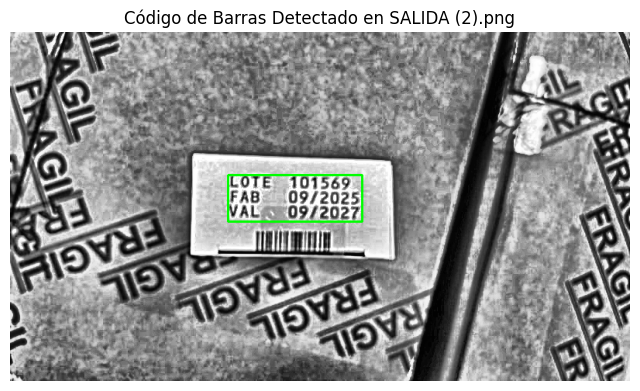

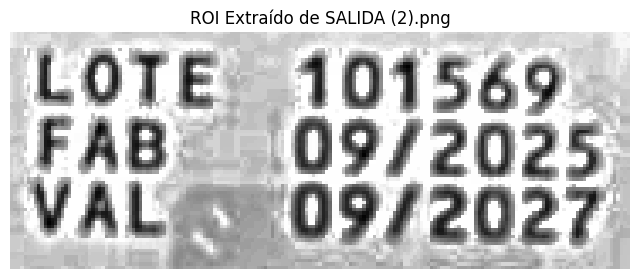

In [22]:
def encontrar_y_extraer_codigo_barras_mejorado(nombre_archivo, datos_imagen):
    """
    Versión mejorada que filtra los candidatos por su relación de aspecto para evitar falsos positivos.
    """
    print(f"\n--- Procesando imagen: {nombre_archivo} ---")

    # 1. Leer la imagen
    # Como tus imágenes ya están en escala de grises, las leemos directamente así.
    imagen_np = np.frombuffer(datos_imagen, np.uint8)
    gris = cv2.imdecode(imagen_np, cv2.IMREAD_GRAYSCALE)

    # Hacemos una copia a color para poder dibujar el rectángulo verde al final
    imagen_para_dibujar = cv2.cvtColor(gris, cv2.COLOR_GRAY2BGR)

    # 2. Resaltar el código de barras usando gradientes (mismo método)
    gradX = cv2.Sobel(gris, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
    gradY = cv2.Sobel(gris, ddepth=cv2.CV_32F, dx=0, dy=1, ksize=-1)
    gradiente = cv2.subtract(gradX, gradY)
    gradiente = cv2.convertScaleAbs(gradiente)

    # 3. Limpiar la imagen del gradiente
    desenfocado = cv2.blur(gradiente, (9, 9))
    _, umbral = cv2.threshold(desenfocado, 225, 255, cv2.THRESH_BINARY)

    # 4. Operaciones Morfológicas para unir las barras
    # Usamos un kernel ligeramente más ancho para asegurar la conexión
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 7))
    cerrado = cv2.morphologyEx(umbral, cv2.MORPH_CLOSE, kernel)

    # Reducimos las iteraciones para no destruir el contorno del código de barras
    cerrado = cv2.erode(cerrado, None, iterations=2)
    cerrado = cv2.dilate(cerrado, None, iterations=2)

    # 5. Encontrar contornos y filtrar por forma (¡LA MEJORA CLAVE!)
    contornos, _ = cv2.findContours(cerrado.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contornos) == 0:
        print("No se encontraron contornos.")
        mostrar_imagen("Imagen Original", gris)
        return

    # Ordenamos los contornos por área, de mayor a menor
    contornos = sorted(contornos, key=cv2.contourArea, reverse=True)

    caja_encontrada = None # Aquí guardaremos las coordenadas del código de barras

    # Iteramos sobre los contornos encontrados
    for c in contornos:
        # Obtenemos el rectángulo que encierra al contorno
        (x, y, w, h) = cv2.boundingRect(c)

        # Calculamos la relación de aspecto (ancho / alto)
        aspect_ratio = w / float(h)

        # ¡FILTRO! Un código de barras debe ser significativamente más ancho que alto.
        # Ajusta este valor si es necesario (valores entre 2.0 y 4.0 suelen funcionar bien).
        if aspect_ratio > 2.88:
            caja_encontrada = (x, y, w, h)
            break # Encontramos nuestro código de barras, salimos del bucle

    # 6. Extraer el ROI si se encontró una caja válida
    if caja_encontrada is not None:
        (x, y, w, h) = caja_encontrada

        # Añadimos un pequeño margen para asegurar que capturamos todo
        margen = 5
        roi = gris[y-margen:y+h+margen, x-margen:x+w+margen]

        # Dibujamos el rectángulo en la imagen original
        cv2.rectangle(imagen_para_dibujar, (x, y), (x + w, y + h), (0, 255, 0), 2)

        # Mostramos los resultados
        mostrar_imagen(f"Código de Barras Detectado en {nombre_archivo}", imagen_para_dibujar)
        mostrar_imagen(f"ROI Extraído de {nombre_archivo}", roi)
    else:
        print(f"No se pudo encontrar un contorno con la forma de un código de barras en {nombre_archivo}.")
        mostrar_imagen("Detección Fallida", gris)

# --- Bucle principal para procesar todas las imágenes subidas ---
for fn, content in uploaded.items():
    encontrar_y_extraer_codigo_barras_mejorado(fn, content)

In [1]:
import cv2
import numpy as np
from google.colab import files
from matplotlib import pyplot as plt
import io

# Función para mostrar imágenes en Colab
def mostrar_imagen(titulo, imagen, es_bgr=False):
    """Muestra una imagen usando matplotlib."""
    plt.figure(figsize=(8, 6))
    if es_bgr:
        # Convertir BGR (OpenCV) a RGB (matplotlib)
        plt.imshow(cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB))
    else:
        # Asumir que es escala de grises
        plt.imshow(imagen, cmap='gray')
    plt.title(titulo)
    plt.axis('off')
    plt.show()

# Sube los archivos a Colab
print("Por favor, sube las imágenes en blanco y negro que quieres procesar:")
uploaded = files.upload()

Por favor, sube las imágenes en blanco y negro que quieres procesar:


Saving SALIDA.png to SALIDA (3).png



--- Procesando imagen: SALIDA (3).png ---


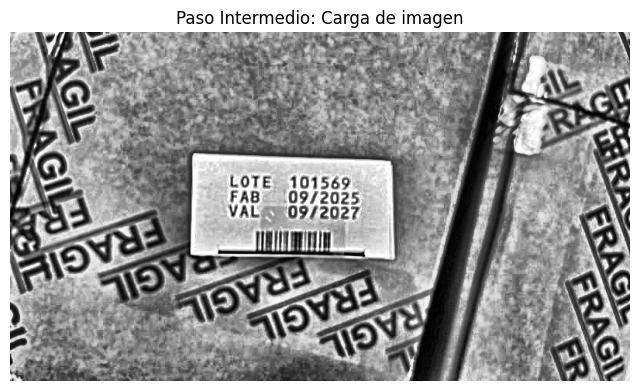

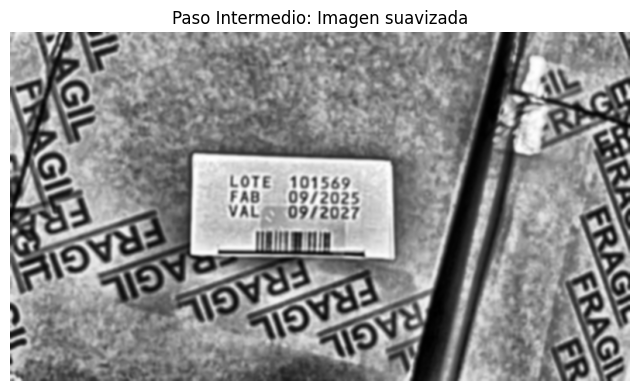

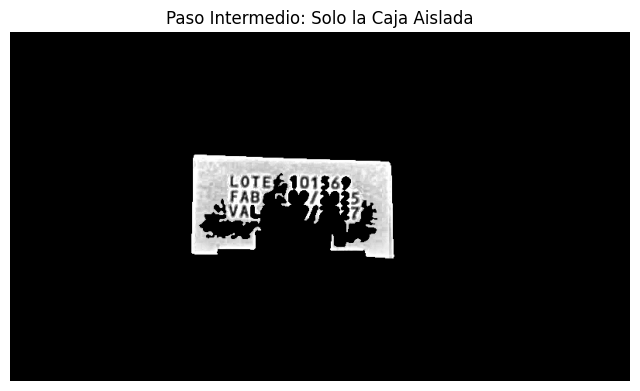

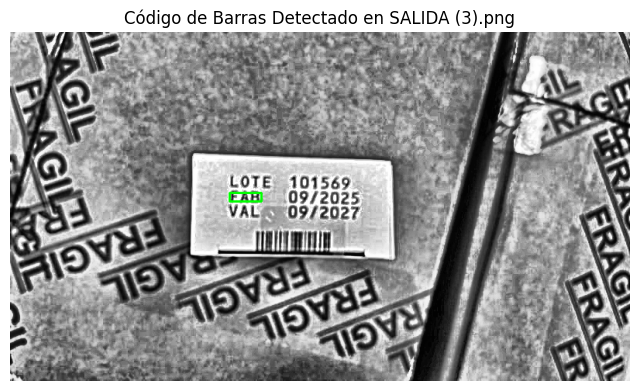

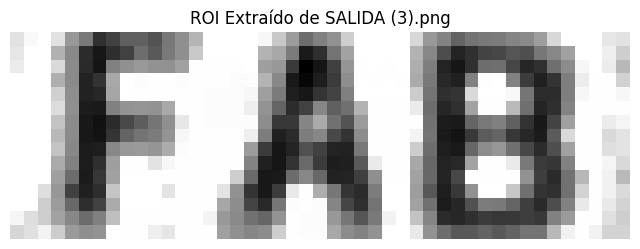

In [8]:
def encontrar_codigo_en_caja(nombre_archivo, datos_imagen):
    """
    Enfoque de dos pasos:
    1. Detecta la caja blanca del medicamento.
    2. Busca el código de barras únicamente dentro de esa caja.
    """
    print(f"\n--- Procesando imagen: {nombre_archivo} ---")

    # --- PASO 1: ENCONTRAR LA CAJA DEL MEDICAMENTO ---

    # Cargar la imagen en escala de grises
    imagen_np = np.frombuffer(datos_imagen, np.uint8)
    gris = cv2.imdecode(imagen_np, cv2.IMREAD_GRAYSCALE)

    # Debug
    mostrar_imagen("Paso Intermedio: Carga de imagen", gris) # Descomentar para depurar

    # Crear una copia a color para dibujar el resultado final
    imagen_para_dibujar = cv2.cvtColor(gris, cv2.COLOR_GRAY2BGR)

    # Suavizar la imagen y aplicar un umbral para aislar las zonas más blancas (la caja)
    blur = cv2.GaussianBlur(gris, (7, 7), 0)
    _, umbral_caja = cv2.threshold(blur, 200, 255, cv2.THRESH_BINARY)

    # Debug
    mostrar_imagen("Paso Intermedio: Imagen suavizada", blur) # Descomentar para depurar

    # Encontrar los contornos en la imagen umbralizada
    contornos_caja, _ = cv2.findContours(umbral_caja, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contornos_caja) == 0:
        print("No se pudo encontrar el contorno de la caja del medicamento.")
        return

    # Asumir que el contorno más grande es la caja
    caja_contour = max(contornos_caja, key=cv2.contourArea)

    # --- PASO 2: CREAR UNA MÁSCARA Y BUSCAR EL CÓDIGO DENTRO DE ELLA ---

    # Crear una imagen negra (máscara) del mismo tamaño que la original
    mascara = np.zeros(gris.shape, dtype="uint8")
    # Dibujar el contorno de la caja en blanco sobre la máscara
    cv2.drawContours(mascara, [caja_contour], -1, 255, -1) # -1 para rellenar

    # Aplicar la máscara a la imagen original. Esto deja solo la caja y pone el resto en negro.
    imagen_solo_caja = cv2.bitwise_and(gris, gris, mask=mascara)

    # Debug
    mostrar_imagen("Paso Intermedio: Solo la Caja Aislada", imagen_solo_caja) # Descomentar para depurar

    # Ahora, aplicamos la detección de gradientes sobre la imagen limpia (solo la caja)
    gradX = cv2.Sobel(imagen_solo_caja, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
    gradiente = cv2.convertScaleAbs(gradX)

    # Limpiamos y unimos las barras del código de barras
    desenfocado = cv2.blur(gradiente, (9, 9))
    _, umbral_barcode = cv2.threshold(desenfocado, 225, 255, cv2.THRESH_BINARY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 7))
    cerrado = cv2.morphologyEx(umbral_barcode, cv2.MORPH_CLOSE, kernel)
    cerrado = cv2.erode(cerrado, None, iterations=2)
    cerrado = cv2.dilate(cerrado, None, iterations=2)

    # Encontrar los contornos del código de barras en la imagen limpia
    contornos_barcode, _ = cv2.findContours(cerrado.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contornos_barcode) == 0:
        print("Se encontró la caja, pero no el código de barras dentro de ella.")
        return

    # Obtener el contorno más grande, que debería ser el código de barras
    c = max(contornos_barcode, key=cv2.contourArea)
    (x, y, w, h) = cv2.boundingRect(c)

    # --- PASO 3: EXTRAER Y MOSTRAR RESULTADOS ---

    # Añadir un pequeño margen para asegurar que el recorte sea completo
    margen = 2
    # Recortar el ROI de la imagen original en escala de grises
    roi = gris[y-margen:y+h+margen, x-margen:x+w+margen]

    # Dibujar un rectángulo verde alrededor del código de barras encontrado
    cv2.rectangle(imagen_para_dibujar, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Mostrar los resultados finales
    mostrar_imagen(f"Código de Barras Detectado en {nombre_archivo}", imagen_para_dibujar, es_bgr=True)
    mostrar_imagen(f"ROI Extraído de {nombre_archivo}", roi)


# --- Bucle principal para procesar todas las imágenes subidas ---
for fn, content in uploaded.items():
    encontrar_codigo_en_caja(fn, content)

In [3]:
import cv2
import numpy as np
from google.colab import files
from matplotlib import pyplot as plt
import io

# Función para mostrar imágenes en Colab
def mostrar_imagen(titulo, imagen, es_bgr=False):
    """Muestra una imagen usando matplotlib."""
    plt.figure(figsize=(8, 6))
    if es_bgr:
        plt.imshow(cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(imagen, cmap='gray')
    plt.title(titulo)
    plt.axis('off')
    plt.show()

# Sube los archivos a Colab
print("Por favor, sube las imágenes que quieres procesar:")
uploaded = files.upload()

Por favor, sube las imágenes que quieres procesar:


Saving salida2.png to salida2.png



--- Procesando imagen: salida2.png ---


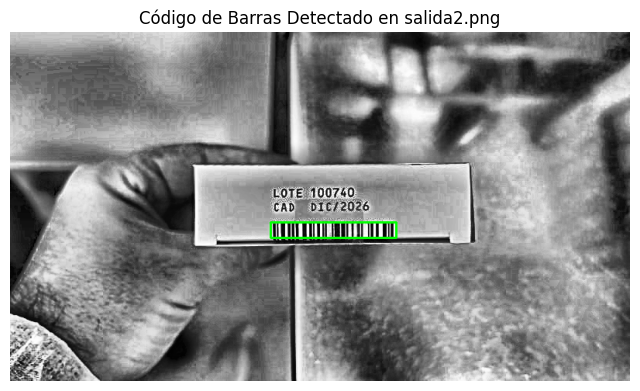

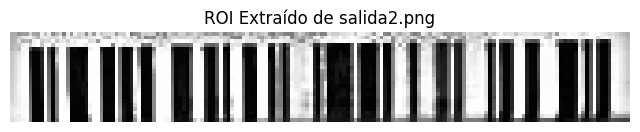

In [4]:
def encontrar_codigo_por_recorte(nombre_archivo, datos_imagen):
    """
    CORRECCIÓN:
    1. Detecta la caja blanca del medicamento.
    2. RECORTA esa región de la imagen original (enfoque no destructivo).
    3. Busca el código de barras únicamente dentro de ese recorte.
    """
    print(f"\n--- Procesando imagen: {nombre_archivo} ---")

    # Cargar la imagen en escala de grises
    imagen_np = np.frombuffer(datos_imagen, np.uint8)
    gris = cv2.imdecode(imagen_np, cv2.IMREAD_GRAYSCALE)

    imagen_para_dibujar = cv2.cvtColor(gris, cv2.COLOR_GRAY2BGR)

    # --- PASO 1: ENCONTRAR LA CAJA DEL MEDICAMENTO (sin cambios) ---
    blur = cv2.GaussianBlur(gris, (7, 7), 0)
    # Ajustamos el umbral para ser un poco más inclusivo con los blancos
    _, umbral_caja = cv2.threshold(blur, 190, 255, cv2.THRESH_BINARY)
    contornos_caja, _ = cv2.findContours(umbral_caja, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contornos_caja) == 0:
        print("No se pudo encontrar el contorno de la caja del medicamento.")
        return

    caja_contour = max(contornos_caja, key=cv2.contourArea)

    # --- PASO 2: RECORTAR LA REGIÓN DE LA CAJA (LA CORRECCIÓN CLAVE) ---

    # En lugar de crear una máscara, obtenemos las coordenadas del rectángulo de la caja
    (x_caja, y_caja, w_caja, h_caja) = cv2.boundingRect(caja_contour)

    # Recortamos la región de interés (la caja) de la imagen de grises original.
    # Esta operación NO destruye el contenido (el código de barras se mantiene intacto).
    caja_recortada = gris[y_caja:y_caja+h_caja, x_caja:x_caja+w_caja]

    # (Opcional) Muestra el recorte de la caja para verificar que es correcto
    # mostrar_imagen("Paso Intermedio: Recorte de la Caja", caja_recortada)

    # --- PASO 3: BUSCAR EL CÓDIGO DENTRO DEL RECORTE ---

    # Ahora, toda la lógica de detección se aplica a la imagen pequeña y limpia 'caja_recortada'
    gradX = cv2.Sobel(caja_recortada, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
    gradiente = cv2.convertScaleAbs(gradX)

    desenfocado = cv2.blur(gradiente, (9, 9))
    _, umbral_barcode = cv2.threshold(desenfocado, 225, 255, cv2.THRESH_BINARY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 7))
    cerrado = cv2.morphologyEx(umbral_barcode, cv2.MORPH_CLOSE, kernel)
    cerrado = cv2.erode(cerrado, None, iterations=2)
    cerrado = cv2.dilate(cerrado, None, iterations=2)

    contornos_barcode, _ = cv2.findContours(cerrado.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contornos_barcode) == 0:
        print("Se encontró la caja, pero no el código de barras dentro de ella.")
        return

    # Encontrar el contorno del código de barras (el más grande dentro del recorte)
    c_barcode = max(contornos_barcode, key=cv2.contourArea)
    (x_bc, y_bc, w_bc, h_bc) = cv2.boundingRect(c_barcode)

    # --- PASO 4: EXTRAER Y MOSTRAR RESULTADOS ---

    # Para dibujar en la imagen original, debemos sumar las coordenadas del recorte de la caja
    # a las coordenadas del código de barras que encontramos dentro de ese recorte.
    x_final = x_caja + x_bc
    y_final = y_caja + y_bc

    # Dibujar el rectángulo verde en la imagen completa
    cv2.rectangle(imagen_para_dibujar, (x_final, y_final), (x_final + w_bc, y_final + h_bc), (0, 255, 0), 2)

    # El ROI final se recorta de la imagen original usando las coordenadas finales
    margen = 2
    roi_final = gris[y_final-margen : y_final+h_bc+margen, x_final-margen : x_final+w_bc+margen]

    # Mostrar los resultados
    mostrar_imagen(f"Código de Barras Detectado en {nombre_archivo}", imagen_para_dibujar, es_bgr=True)
    mostrar_imagen(f"ROI Extraído de {nombre_archivo}", roi_final)


# --- Bucle principal para procesar todas las imágenes subidas ---
for fn, content in uploaded.items():
    encontrar_codigo_por_recorte(fn, content)